In [1]:
import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer
from scouting_gym.scouting_env import ScoutingEnv
from gym.envs.registration import register
from IPython.display import clear_output

register(
    id='Scouting-v0',
    entry_point='scouting_gym.scouting_env_real:ScoutingEnvInference'
)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
env = gym.make('Scouting-v0')

print(env.observation_space)

[ERROR] [1611928184.205434, 0.000000]: Current /scan not ready yet, retrying for getting laser_scan
[ERROR] [1611928185.222829, 0.000000]: Current /scan not ready yet, retrying for getting laser_scan
[ERROR] [1611928186.238321, 0.000000]: Current /scan not ready yet, retrying for getting laser_scan
[ERROR] [1611928187.259575, 0.000000]: Current /scan not ready yet, retrying for getting laser_scan
[ERROR] [1611928188.279530, 0.000000]: Current /scan not ready yet, retrying for getting laser_scan
[ERROR] [1611928189.293793, 0.000000]: Current /scan not ready yet, retrying for getting laser_scan
[ERROR] [1611928190.313309, 0.000000]: Current /scan not ready yet, retrying for getting laser_scan
[ERROR] [1611928191.326492, 0.000000]: Current /scan not ready yet, retrying for getting laser_scan
[ERROR] [1611928192.343108, 0.000000]: Current /scan not ready yet, retrying for getting laser_scan
[ERROR] [1611928193.360483, 0.000000]: Current /scan not ready yet, retrying for getting laser_scan


(array([0.5083393 , 1.8068304 , 0.60584724, 2.1872406 , 1.0981935 ,
       0.4478334 , 0.11275916, 0.7390865 , 3.294712  , 1.7011781 ,
       2.179646  , 2.0907748 , 0.08764062, 3.1693015 , 2.1452436 ,
       2.8086035 , 1.0766923 , 0.18859774], dtype=float32), array([-3.263752 ,  1.5612859], dtype=float32), array([ 0.5397634 , -0.52603203], dtype=float32))
Tuple(Box(0.0, 4.0, (18,), float32), Box(-10.0, 10.0, (2,), float32), Box(-1.0, 1.0, (2,), float32))


[-4.59201993658371, 2.4037089724224807, -0.1117812677257724]


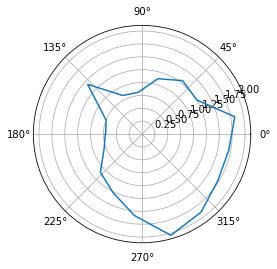

In [3]:
import matplotlib.pyplot as plt
import numpy as np
obs = env.reset()
thetas = np.linspace(-3.14, 3.14, 18)
plt.figure()
plt.polar(thetas, obs[0])
plt.show()

In [4]:
print(env.offs_x, env.offs_y)

-1.9829870348639111 -1.744520828712645


In [30]:
import time
env.reset()
for _ in range(50):
    #obs, reward, done, _ = env.step(1)
    obs, reward, done, _ = env.step(1)

    clear_output(wait=True)
    print(obs[1], obs[2])
    if done:
        print('break')
        break
print(obs)
env.reset()

[2.0461597  0.69780225] [0.00249521 0.00662212]
(array([1.8497185 , 0.9778511 , 0.76388377, 0.66989803, 0.9958483 ,
       1.1698219 , 1.3018017 , 1.4397807 , 2.9415522 , 2.081683  ,
       2.1636705 , 2.291651  , 2.6735928 , 2.317647  , 1.8277217 ,
       1.1878191 , 1.2298127 , 3.99      ], dtype=float32), array([2.0461597 , 0.69780225], dtype=float32), array([0.00249521, 0.00662212], dtype=float32))
[-0.2328857868381443, -1.1929179055514443, -0.11370100552919662]


(array([1.8857129 , 1.0198448 , 0.74788606, 0.6798965 , 1.1478251 ,
        1.1598234 , 1.293803  , 1.4057859 , 2.929554  , 2.0336905 ,
        2.1256764 , 2.265655  , 2.705588  , 2.3196468 , 1.8357207 ,
        1.2138152 , 1.2358118 , 3.99      ], dtype=float32),
 array([2.0328858, 0.6929179], dtype=float32),
 array([-0.99, -0.99], dtype=float32))

In [5]:
print(obs)

(array([2.371639 , 1.5197686, 1.083835 , 1.5697609, 3.99     , 1.7457341,
       0.9118612, 0.781881 , 0.6758971, 0.6519007, 1.18182  , 1.333797 ,
       1.549764 , 3.1415217, 2.2296605, 2.3456428, 2.371639 , 2.547612 ],
      dtype=float32), array([0.0542413 , 0.32386878], dtype=float32), array([0.99     , 0.1522624], dtype=float32))


In [4]:
ray.init()

2021-01-29 11:16:59,811	INFO resource_spec.py:223 -- Starting Ray with 6.35 GiB memory available for workers and up to 3.19 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-01-29 11:17:00,556	INFO services.py:1191 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.178.21',
 'raylet_ip_address': '192.168.178.21',
 'redis_address': '192.168.178.21:6379',
 'object_store_address': '/tmp/ray/session_2021-01-29_11-16-59_802105_59880/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-29_11-16-59_802105_59880/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2021-01-29_11-16-59_802105_59880'}

In [5]:
config = {
    "env": ScoutingEnvInference,  # or "corridor" if registered above
    "env_config": {
        "corridor_length": 5,
    },
    # Use GPUs iff `RLLIB_NUM_GPUS` env var set to > 0.

    "num_gpus": 0,
    "num_workers": 1,  # parallelism
    "model": {
        "fcnet_hiddens": [256, ],
        #"fcnet_hiddens": tune.grid_search([[64, 64, ], [128, 128, ], [256, 256, ]])
    }
}

In [6]:
def load(checkpoint_path, config):
    """
    Load a trained RLlib agent from the specified path. Call this before testing a trained agent.
    :param path: Path pointing to the agent's saved checkpoint (only used for RLlib agents)
    """
    agent = PPOTrainer(config=config)
    agent.restore(checkpoint_path)
    return agent
import numpy as np
from gym import spaces
def test(agent, env):
    """Test trained agent for a single episode. Return the episode reward"""
    # instantiate env class

    # run until episode ends
    episode_reward = 0
    done = False
    obs = env.reset()
    while not done:
        action = agent.compute_action(obs)
        obs, reward, done, info = env.step(action)
        clear_output(wait=True)
        print(obs[1])
        episode_reward += reward
    env.reset()
    return episode_reward

In [7]:
checkpoint_path = '/home/dschori/Downloads/checkpoint_409/checkpoint-409'

In [8]:
agent = load(checkpoint_path=checkpoint_path, config=config)

2021-01-29 11:17:01,201	INFO trainer.py:605 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-01-29 11:17:01,208	INFO trainer.py:630 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=59982) WARNING:tensorflow:From /home/dschori/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=59982) Instructions for updating:
(pid=59982) non-resource variables are not supported in the long term
2021-01-29 11:17:07,075	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2021-01-29 11:17:07,179	INFO trainable.py:472 -- Restored on 192.168.178.21 from checkpoint: /home/dschori/Downloads/checkpoint_409/checkpoint-409
2021-01-29 11:17:07,180	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 409, '_timesteps_total

(array([1.8165778 , 1.1855983 , 2.9868762 , 0.61482066, 2.7433605 ,
       1.0392433 , 3.497857  , 1.100331  , 1.6122637 , 1.7117525 ,
       3.4907255 , 3.2120004 , 1.905972  , 3.5684972 , 1.5556544 ,
       3.31941   , 2.6122408 , 1.7070675 ], dtype=float32), array([5.3826356, 0.8637818], dtype=float32), array([-0.06253518, -0.02460722], dtype=float32))


In [9]:
import time
time_now = time.time()
action = agent.compute_action(env.observation_space.sample())
print(time.time() - time_now)

0.04593706130981445
(pid=59982) (array([2.921298  , 2.6746264 , 0.11800649, 1.0991788 , 3.8545022 ,
(pid=59982)        0.5757436 , 2.1891992 , 3.5955355 , 0.13212447, 1.7759067 ,
(pid=59982)        2.388409  , 2.801806  , 2.5895336 , 1.1801786 , 0.09340436,
(pid=59982)        0.6788922 , 3.2009115 , 1.5404531 ], dtype=float32), array([ 7.516656 , -1.8715256], dtype=float32), array([-0.8431317 ,  0.44957113], dtype=float32))


In [23]:
env.target_p = (-4.7, -2.1)

In [27]:
episode_reward = test(agent=agent, env=env)
episode_reward

[ 0.24788746 -3.4223    ]
[-4.856665549675576, 1.385850608117868, -0.0929273872065608]


-95.10881371961395

(pid=59982) Error:   TF_NAN_INPUT: Ignoring transform for child_frame_id "camera_t265_pose_frame" from authority "/camera_t265/realsense2_camera_manager" because of a nan value in the transform (nan nan -nan) (nan nan -nan -nan)
(pid=59982)          at line 240 in /tmp/binarydeb/ros-noetic-tf2-0.7.5/src/buffer_core.cpp
(pid=59982) Error:   TF_DENORMALIZED_QUATERNION: Ignoring transform for child_frame_id "camera_t265_pose_frame" from authority "/camera_t265/realsense2_camera_manager" because of an invalid quaternion in the transform (nan nan -nan -nan)
(pid=59982)          at line 255 in /tmp/binarydeb/ros-noetic-tf2-0.7.5/src/buffer_core.cpp
(pid=59982) Error:   TF_NAN_INPUT: Ignoring transform for child_frame_id "camera_t265_pose_frame" from authority "/camera_t265/realsense2_camera_manager" because of a nan value in the transform (nan nan -nan) (nan nan -nan -nan)
(pid=59982)          at line 240 in /tmp/binarydeb/ros-noetic-tf2-0.7.5/src/buffer_core.cpp
(pid=59982) Error:   TF_DENO

In [17]:
agent.compute_action(env.reset())

[-3.806096501263063, -0.16704603518618333, -0.11311608421588906]


1